# Study the data with the OCTs and the layer thickness

In [87]:
import sys
import os
from skimage import exposure
import pandas as pd 
import numpy as np 
import cv2
import glob
from helpers import *
import matplotlib.pyplot as plt
%matplotlib inline


- feed pca with gradient image

## 1. Load the data
- X: OCT images and thickness (stacked vertically)
- y: corresponding labels

In [88]:
X, y = getBalancedStackedXYData()
print(X.shape)
print(y.shape)

xmin = 70
xmin_thick = 6

(193536, 76)
(193536,)


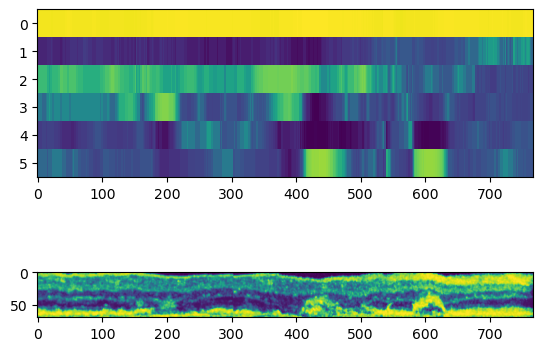

In [89]:
fig, axes = plt.subplots(2,1)
axes[0].imshow(X[-768:,-xmin_thick:].transpose(), aspect='auto', interpolation='nearest')
axes[1].imshow(X[-768:,:-xmin_thick].transpose()) 

In [90]:
print(X[-7,-xmin_thick:])

[0.97840071 0.57676761 0.18836519 0.21439097 0.28373387 0.26158958]


### 1.2 Distribution of the thicknesses

In [91]:
# no normalization on X_thick
X, y = getBalancedStackedXYData(normmode_thick=None)
X_thickness = X[:,-xmin_thick:]
mask0 = np.array(1-y).astype(bool)
mask1 = np.array(y).astype(bool)
X_thick0 = X_thickness[mask0]
X_thick1 = X_thickness[mask1]

In [92]:
X_thickness[:10]

array([[38.,  8., 20., 22., 20., 18.],
       [38.,  8., 20., 22., 20., 18.],
       [38.,  8., 20., 24., 18., 18.],
       [38.,  8., 20., 24., 19., 17.],
       [38.,  8., 21., 26., 16., 17.],
       [38.,  8., 21., 26., 16., 17.],
       [38.,  8., 22., 25., 16., 17.],
       [38.,  8., 22., 25., 15., 18.],
       [38.,  8., 22., 25., 15., 18.],
       [37.,  9., 23., 24., 15., 18.]])

In [59]:
if (y[mask0] == 0).all():
    print("mask 0 is right.")
if (y[mask1] == 1).all():
    print("mask 1 is right.")

mask 0 is right.
mask 1 is right.


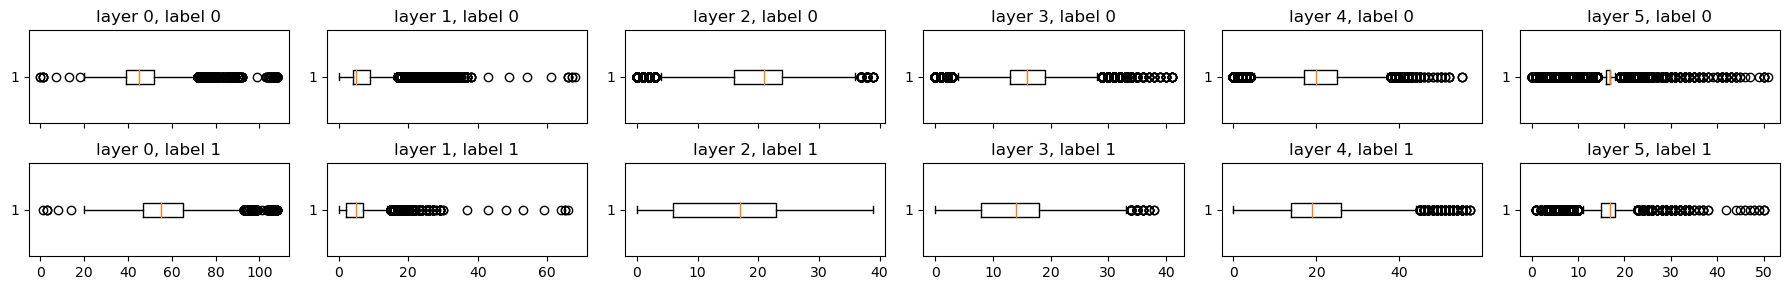

In [60]:
fig, axes = plt.subplots(2, xmin_thick, figsize=(18,3), sharex='col')
for i in range(xmin_thick):
    for j in range(2):
        if j==0:
            axes[j,i].boxplot(X_thick0[:, i], vert=False)
            axes[j,i].set_title('layer ' + str(i) + ', label 0')
        else: 
            axes[j,i].boxplot(X_thick1[:, i], vert=False)
            axes[j,i].set_title('layer ' + str(i) + ', label 1')
    

plt.tight_layout()


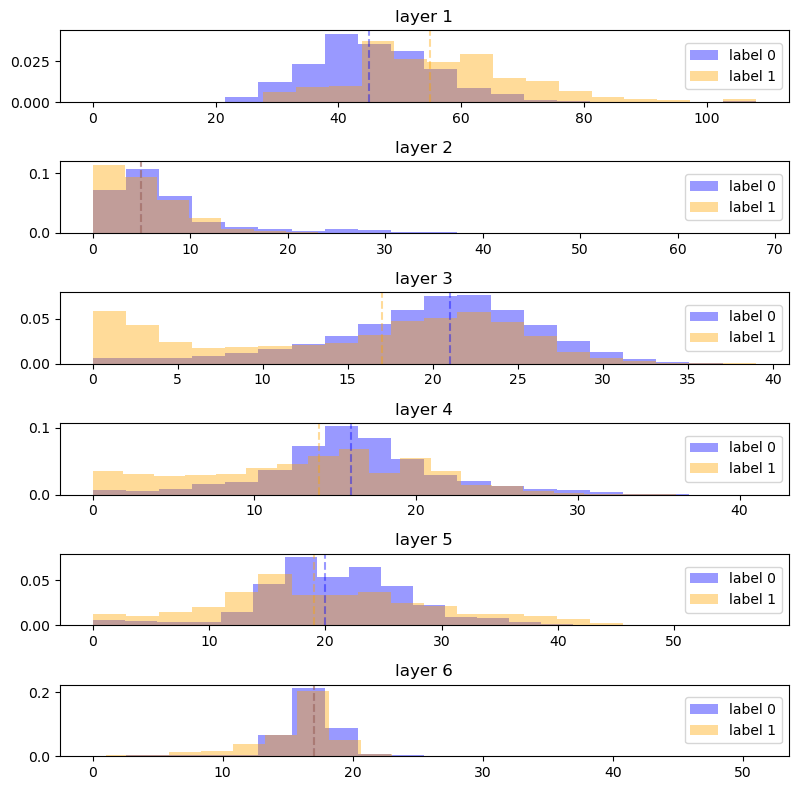

In [86]:
fig, axes = plt.subplots(xmin_thick, figsize=(8,8))
bins = 20
for i in range(xmin_thick):
    axes[i].hist(X_thick0[:, i], density=True, label='label 0', alpha=0.4, bins = bins, color='b')
    axes[i].axvline(np.median(X_thick0[:, i]), linestyle='dashed', color='b', alpha=0.4)
    axes[i].hist(X_thick1[:, i], density=True, label='label 1', alpha=0.4, bins = bins, color='orange')
    axes[i].axvline(np.median(X_thick1[:, i]), linestyle='dashed', color='orange', alpha=0.4)
    axes[i].set_title('layer ' + str(i+1))
    axes[i].legend(loc='right')
plt.tight_layout()


## 2. Simple models on stacked data
We study simple models performance on the classification of the labels. Studied Models:
- Naive Bayes (NB);
- Support Vector Machine (SVM);
- Random Forests (RF).

The following code is inspired from the notebook `C:\Users\line\Desktop\Mauro\2_Preprocessing_Code\amd\prl\ModelComparaisons.ipynb`.

In [6]:
from buildDataset import *
%matplotlib inline
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
root_path =      DATAPATHS["preprocessed"]
from sklearn.model_selection import KFold

In [7]:
# Create a cv that specifies the folds of my dataset, basically to avoid shuffling
# Having 12 control patients, splits should be divisors of 12, eg: 2 fold, 3-fold, 4-fold, 6-fold, 12-fold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

def score_model_PR(model,X,y, params = None, cv=None,plotMatrix = None,plotROC = None,setTreshold = None,ax2 = None,modelname = '',label = None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    #smoter = SMOTE(random_state=42)
    
    scores = []
    y_real = []
    y_proba = []
    
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for fold, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
        # Get the training data
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_fold,y_train_fold) 
        # Fit the model on the upsampled training data
        if params:
            model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        else:
            model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        pred_proba = model_obj.predict_proba(X_val_fold)
        y_real.append(y_val_fold)
        preds = pred_proba[:,1]
        y_proba.append(preds)
        if(plotMatrix):
            # Display confusion matrix
            ConfusionMatrixDisplay.from_estimator(model_obj, X_val_fold, y_val_fold)
            plt.show()
        if(plotROC):
            viz = PrecisionRecallDisplay.from_predictions(
                y_val_fold,
                preds,
                name=f"PR fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
            )

        if(setTreshold != None):
            predictions = (model_obj.predict_proba(X_val_fold)[:,1] >= setTreshold).astype(bool)
        # Score the model on the (non-upsampled) validation data
        else:
            predictions = model_obj.predict(X_val_fold)
        scores.append(recall_score(y_val_fold, predictions))
        scores.append(precision_score(y_val_fold, predictions))
        scores.append(accuracy_score(y_val_fold, predictions))
        scores.append(f1_score(y_val_fold, predictions))
        
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    if(plotROC):
        PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"PR AVG",
                    color="b",
                    lw=2,
                    alpha=0.8,
                    ax=ax,
                )
    if ax2:
        if label != None:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{label}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )
        else:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{str(list(params.items()))} {modelname}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Precision",
        ylabel="Recall",
        title=f"Mean PR curve",
    )

    plt.show()

    return np.array(scores)

### Naive Bayes

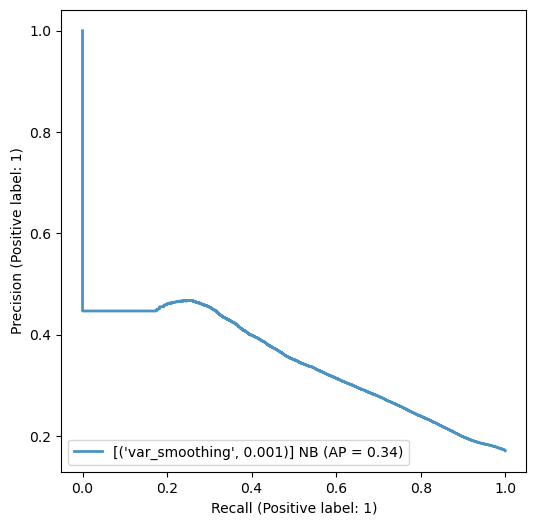

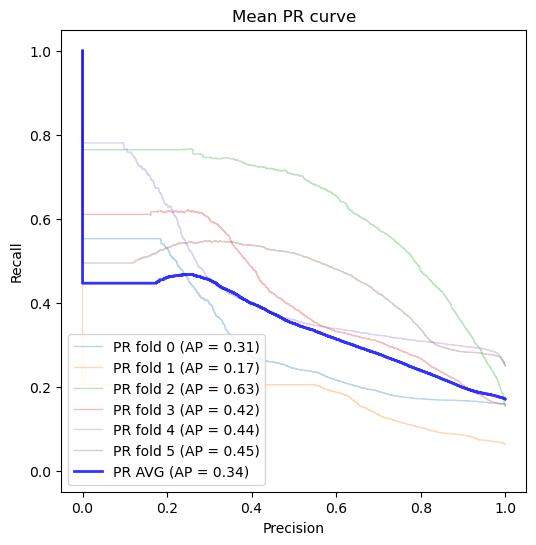

Here are the recall scores: [0.38052405 0.71485743 0.84492754 0.60477506 0.36715705 0.51653048]
Here are the precisions scores: [0.28863839 0.12652736 0.43157783 0.33035137 0.41155743 0.51228026]
Here are the accuracies scores: [0.7531002  0.6764943  0.81014385 0.7452877  0.71453373 0.75948661]
Here are the f1 scores: [0.3282726  0.21500038 0.57132857 0.42729681 0.38809144 0.51439659]


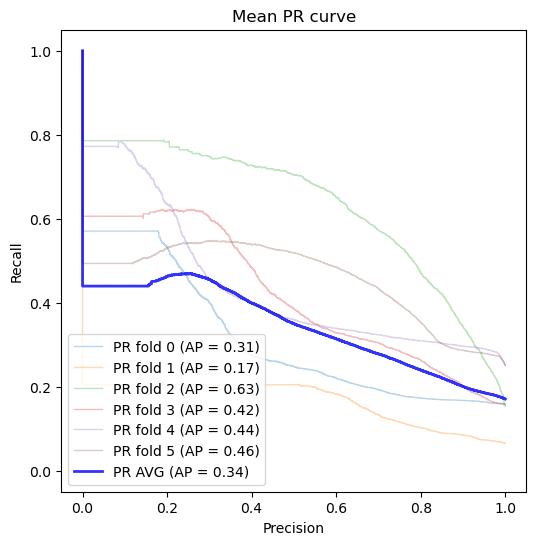

Here are the recall scores: [0.38443488 0.71035518 0.8389234  0.5956985  0.35910977 0.52118165]
Here are the precisions scores: [0.28772135 0.12675176 0.43193689 0.32958515 0.41620519 0.512168  ]
Here are the accuracies scores: [0.7515191  0.67875744 0.81067088 0.74609375 0.71778894 0.75948661]
Here are the f1 scores: [0.32912028 0.21511892 0.57026247 0.42437447 0.38555518 0.51663551]


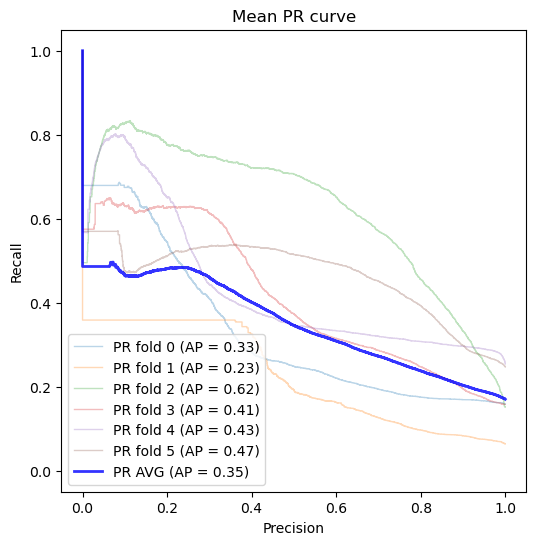

Here are the recall scores: [0.38032851 0.68534267 0.81449275 0.5538674  0.30868855 0.50056568]
Here are the precisions scores: [0.29631322 0.13091257 0.43930765 0.33321462 0.43582461 0.51447028]
Here are the accuracies scores: [0.75855655 0.69853671 0.81656126 0.75576637 0.73102679 0.76032366]
Here are the f1 scores: [0.33310498 0.21983312 0.57076532 0.41609843 0.36140144 0.50742275]


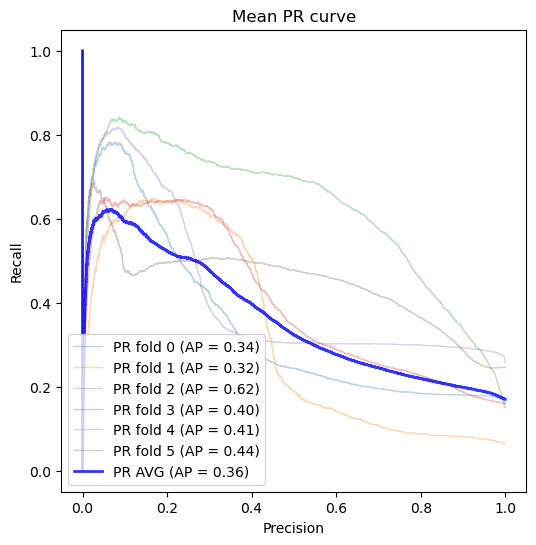

Here are the recall scores: [0.36781384 0.6188094  0.78923395 0.49033149 0.27348171 0.40691389]
Here are the precisions scores: [0.32364074 0.13388895 0.46899606 0.35228239 0.4735467  0.49548446]
Here are the accuracies scores: [0.77790179 0.72829861 0.83463542 0.77827381 0.74590774 0.7515501 ]
Here are the f1 scores: [0.34431631 0.22014593 0.5883624  0.40999835 0.34672406 0.44685257]


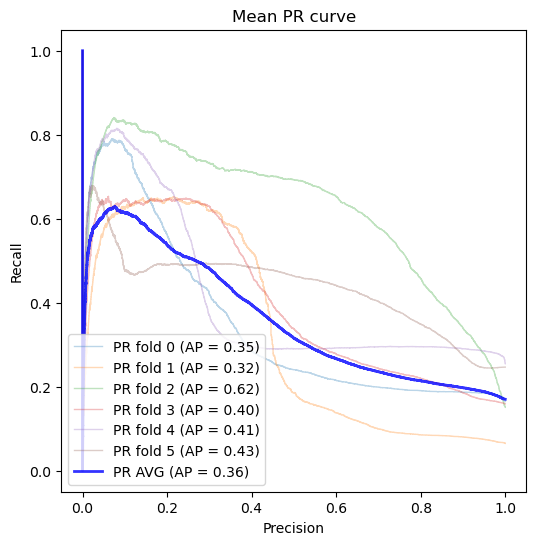

Here are the recall scores: [0.36546734 0.6088044  0.77867495 0.48026835 0.27323023 0.38529227]
Here are the precisions scores: [0.33167702 0.13457923 0.47996427 0.35846834 0.47507652 0.48681703]
Here are the accuracies scores: [0.78264509 0.73313492 0.84052579 0.78329613 0.74637277 0.74823289]
Here are the f1 scores: [0.34775328 0.22043108 0.59387336 0.41052454 0.34693063 0.43014525]


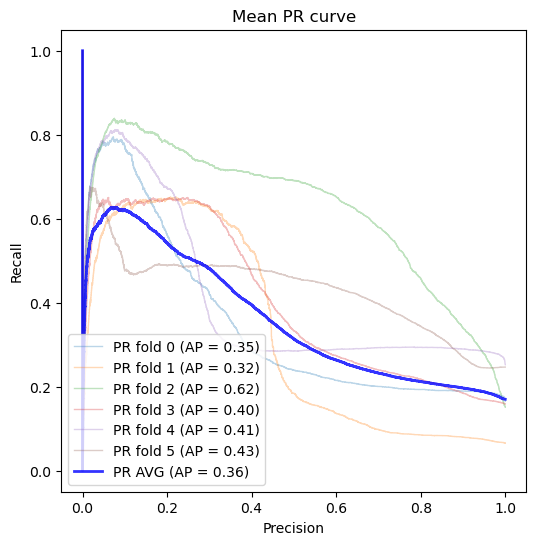

Here are the recall scores: [0.3652718  0.60630315 0.77556936 0.47750592 0.27385892 0.37812696]
Here are the precisions scores: [0.33524767 0.13480147 0.48372934 0.36006547 0.47523456 0.48336815]
Here are the accuracies scores: [0.78453621 0.734437   0.84244792 0.78456721 0.74640377 0.74696181]
Here are the f1 scores: [0.34961632 0.22056415 0.59583267 0.41055221 0.34747926 0.42431937]


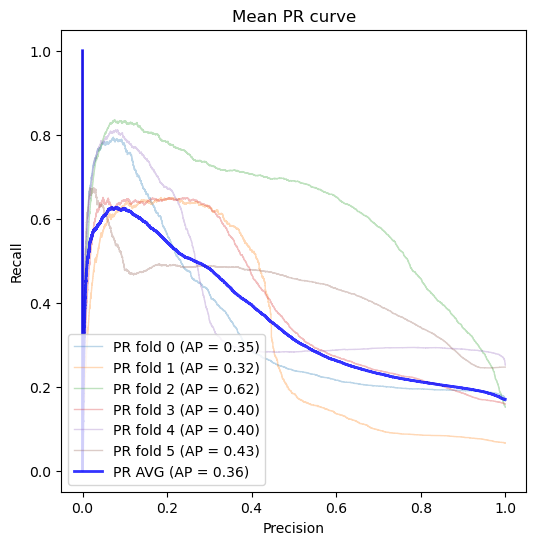

Here are the recall scores: [0.36566289 0.60330165 0.77494824 0.47632202 0.2741104  0.37536141]
Here are the precisions scores: [0.33669427 0.13449314 0.48679932 0.36024474 0.47360417 0.48130239]
Here are the accuracies scores: [0.78521825 0.73480903 0.84396701 0.78481523 0.74590774 0.74618676]
Here are the f1 scores: [0.35058118 0.21995258 0.59797108 0.41023027 0.34724435 0.4217812 ]


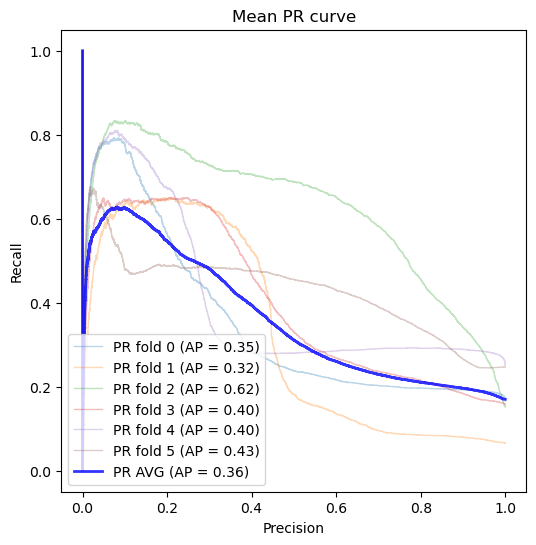

Here are the recall scores: [0.36507626 0.6018009  0.773706   0.47494081 0.27461335 0.37309868]
Here are the precisions scores: [0.33853128 0.13463906 0.49022694 0.36179167 0.47242051 0.47971553]
Here are the accuracies scores: [0.78624132 0.73561508 0.84564112 0.7858693  0.74553571 0.74559772]
Here are the f1 scores: [0.35130304 0.22004756 0.60017666 0.41071581 0.34732824 0.41974261]


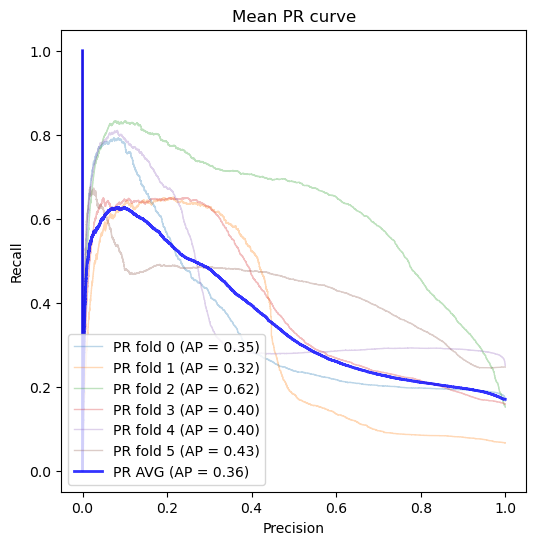

Here are the recall scores: [0.36468518 0.60130065 0.77349896 0.47454617 0.27461335 0.37322439]
Here are the precisions scores: [0.33853694 0.13457232 0.49035306 0.36165414 0.47242051 0.47979961]
Here are the accuracies scores: [0.78630332 0.73564608 0.84570312 0.78583829 0.74553571 0.74562872]
Here are the f1 scores: [0.35112492 0.21992498 0.60020885 0.4104796  0.34732824 0.41985434]


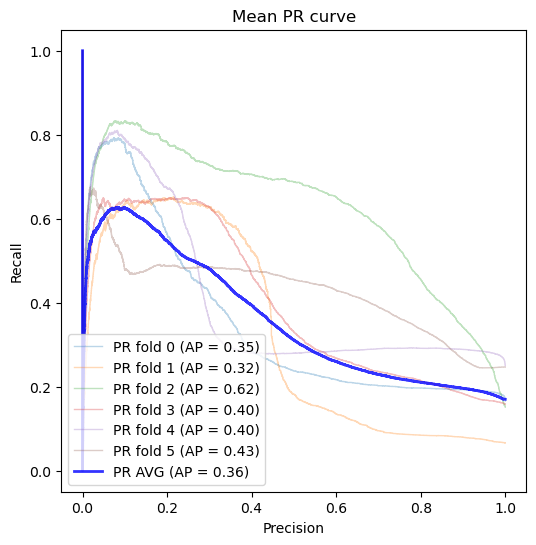

Here are the recall scores: [0.36468518 0.60130065 0.77349896 0.47454617 0.27461335 0.37309868]
Here are the precisions scores: [0.3385984  0.13457232 0.49035306 0.36170853 0.47242051 0.47971553]
Here are the accuracies scores: [0.78633433 0.73564608 0.84570312 0.7858693  0.74553571 0.74559772]
Here are the f1 scores: [0.35115797 0.21992498 0.60020885 0.41051464 0.34732824 0.41974261]


In [8]:
fig2, ax2 = plt.subplots(figsize=(6, 6))
# Example of the model in action, takes <1min
kf = KFold(n_splits=6, shuffle=False)
gridsearch = [1e-3,1e-2,1e-1,1,3,6,10,100,1000,10000]
# X: stacked data.
for smooth in gridsearch:
    params = {
            'var_smoothing': smooth,
        }
    scores = score_model_PR(GaussianNB,X,y,params = params, cv=kf,plotMatrix = False, plotROC = True,ax2 = ax2,modelname = 'NB')
    print(f'Here are the recall scores: {scores[::4]}')
    print(f'Here are the precisions scores: {scores[1::4]}')
    print(f'Here are the accuracies scores: {scores[2::4]}')
    print(f'Here are the f1 scores: {scores[3::4]}')

ax2.plot([0, 1], [0.17, 0.17], "k--", label="chance level (AP = 0.17)")
ax2.legend(loc="upper right")
ax2.set_title(f"Smoothness optimization for GN (raw data)")
fig2
plt.show()

### Random Forest

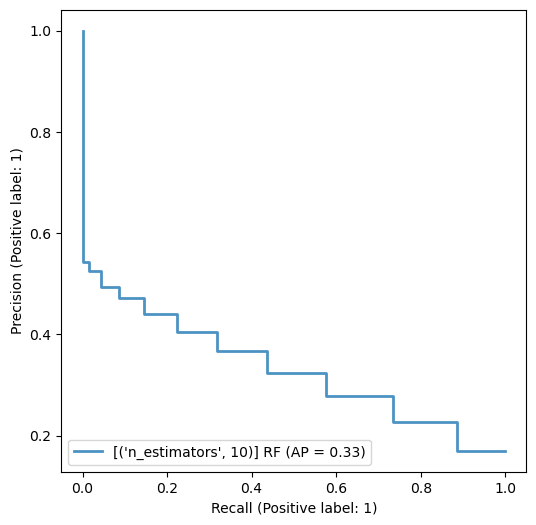

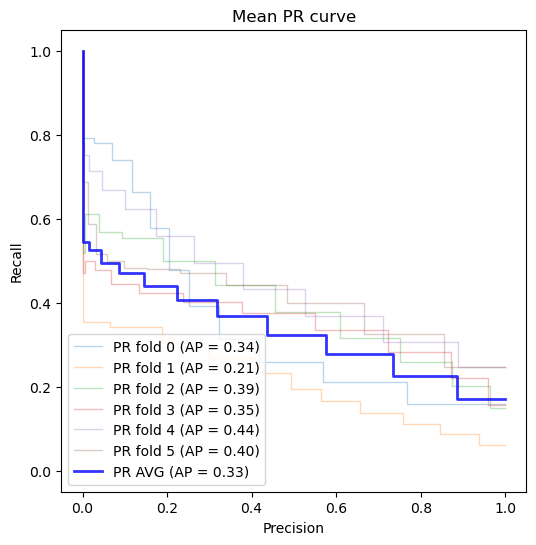

Here are the recall scores: [0.20434102 0.49374687 0.31242236 0.23756906 0.17289073 0.15172847]
Here are the precisions scores: [0.57734807 0.23234463 0.49884298 0.42364532 0.62217195 0.4828    ]
Here are the accuracies scores: [0.85013641 0.86752852 0.8500434  0.82942708 0.77018229 0.75071305]
Here are the f1 scores: [0.30184864 0.31599168 0.38421388 0.30442478 0.27058939 0.23089431]


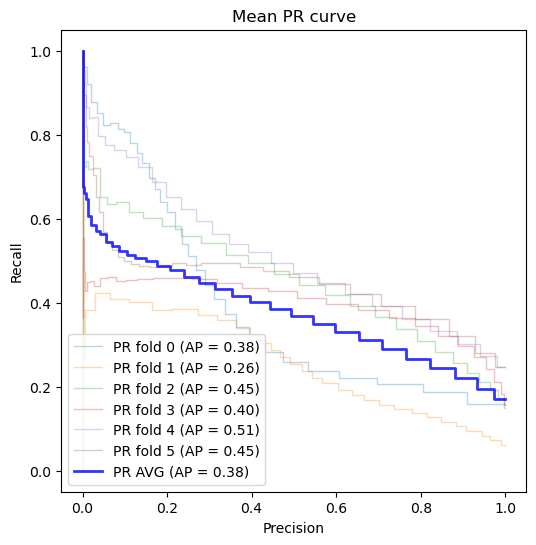

Here are the recall scores: [0.21881111 0.51825913 0.33995859 0.25927388 0.19803848 0.15625393]
Here are the precisions scores: [0.61517317 0.25454545 0.54280992 0.45783972 0.68807339 0.48821681]
Here are the accuracies scores: [0.85444568 0.87608507 0.85828993 0.83537946 0.78013393 0.7515191 ]
Here are the f1 scores: [0.32280398 0.34140715 0.41807766 0.33106576 0.30755712 0.23673936]


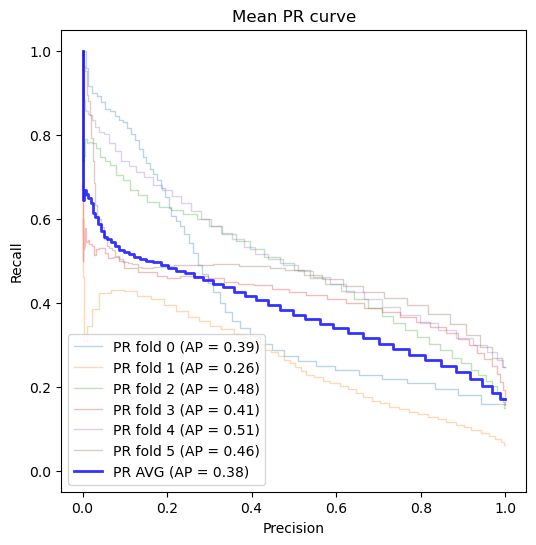

Here are the recall scores: [0.21998436 0.51725863 0.36376812 0.26381215 0.18860807 0.15424261]
Here are the precisions scores: [0.60548977 0.24701386 0.56332158 0.46295014 0.68027211 0.48326113]
Here are the accuracies scores: [0.85360863 0.87236483 0.8625062  0.83624752 0.7780878  0.75074405]
Here are the f1 scores: [0.32271945 0.33435732 0.44206818 0.33609854 0.29533373 0.23384791]


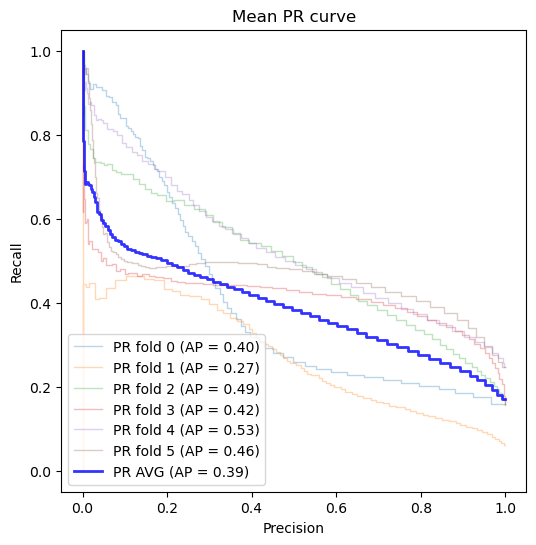

Here are the recall scores: [0.22526398 0.52376188 0.37287785 0.26045777 0.2094807  0.15637964]
Here are the precisions scores: [0.62472885 0.24462617 0.56528562 0.44715447 0.7        0.48517941]
Here are the accuracies scores: [0.85571677 0.8702567  0.86315724 0.83320933 0.78295511 0.75102307]
Here are the f1 scores: [0.33112963 0.33349259 0.4493513  0.32917706 0.32246201 0.23652438]


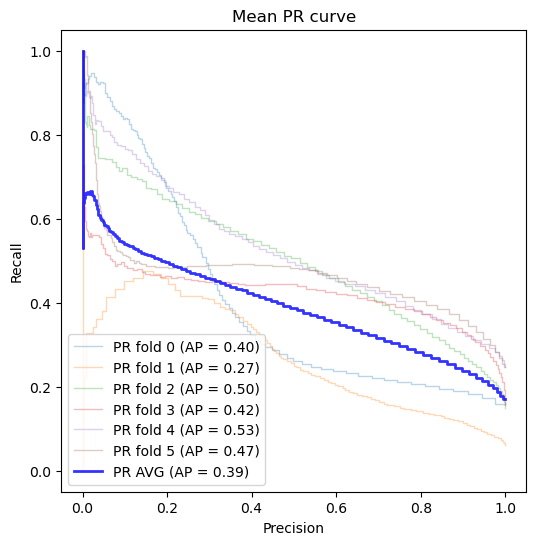

Here are the recall scores: [0.22624169 0.51525763 0.36728778 0.25591949 0.19426631 0.15600251]
Here are the precisions scores: [0.62778079 0.24594078 0.57060148 0.45669014 0.69127517 0.48743126]
Here are the accuracies scores: [0.85605779 0.87205481 0.86387029 0.83525546 0.77994792 0.75139509]
Here are the f1 scores: [0.33261463 0.3329562  0.44690767 0.32802226 0.303298   0.23635844]


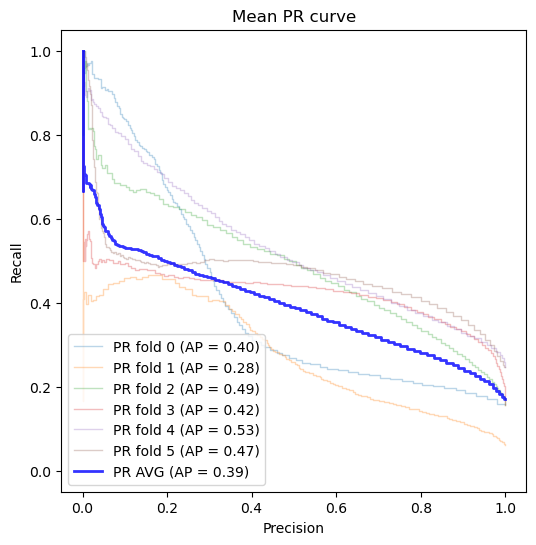

Here are the recall scores: [0.2272194  0.51475738 0.36645963 0.26322021 0.20243933 0.16002514]
Here are the precisions scores: [0.63015184 0.24576069 0.55765595 0.45920826 0.69757366 0.49360217]
Here are the accuracies scores: [0.85633681 0.87202381 0.86160714 0.83553447 0.78171503 0.75235615]
Here are the f1 scores: [0.33400402 0.33268671 0.44227886 0.33462937 0.31380957 0.24169356]


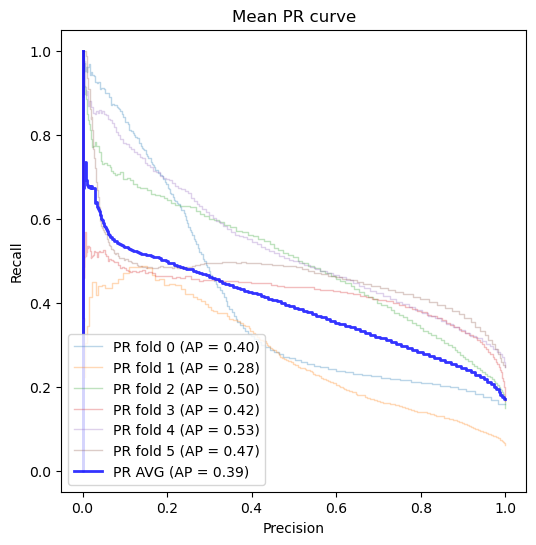

Here are the recall scores: [0.22643723 0.51525763 0.37639752 0.25552486 0.19640387 0.15348837]
Here are the precisions scores: [0.63661352 0.24706165 0.57187795 0.4625     0.69763287 0.48337292]
Here are the accuracies scores: [0.85686384 0.87264385 0.86442832 0.83637153 0.78087798 0.75077505]
Here are the f1 scores: [0.33405452 0.33398184 0.45398926 0.32918149 0.30651491 0.23299304]


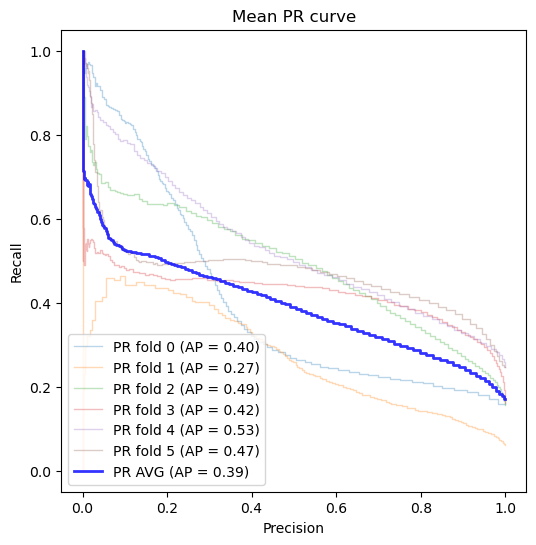

Here are the recall scores: [0.22604615 0.51825913 0.37660455 0.25868193 0.2033195  0.16140792]
Here are the precisions scores: [0.62655827 0.24342105 0.56159308 0.45584145 0.69848812 0.49728892]
Here are the accuracies scores: [0.85593378 0.8703187  0.86263021 0.83500744 0.78193204 0.75294519]
Here are the f1 scores: [0.33223164 0.331255   0.45086132 0.33006042 0.3149591  0.24371263]


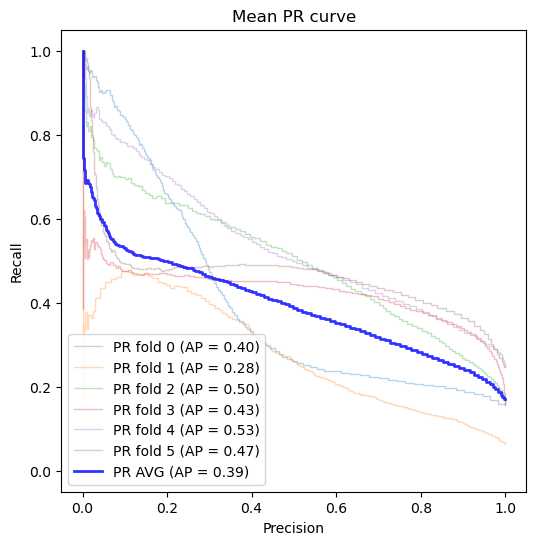

Here are the recall scores: [0.22409073 0.51375688 0.37163561 0.26262826 0.19451779 0.15135135]
Here are the precisions scores: [0.62452316 0.25061005 0.57458387 0.46408647 0.70446266 0.48044693]
Here are the accuracies scores: [0.85562376 0.87465898 0.86470734 0.83649554 0.781281   0.75034102]
Here are the f1 scores: [0.32983163 0.33688699 0.45134524 0.33543347 0.30485762 0.23018832]


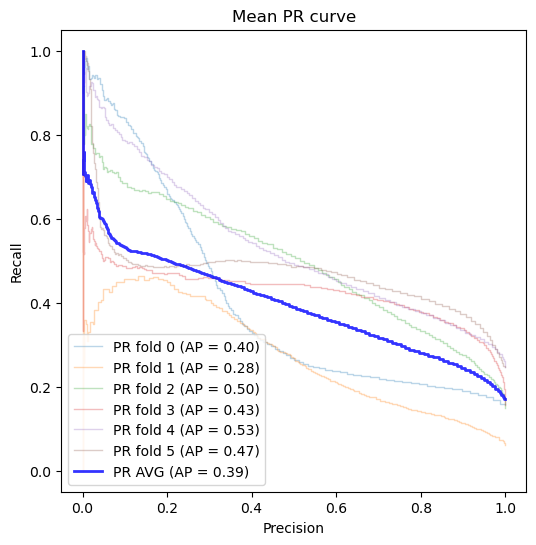

Here are the recall scores: [0.22506844 0.52526263 0.3747412  0.26183899 0.20495411 0.15952231]
Here are the precisions scores: [0.63172338 0.25179856 0.57351077 0.45664143 0.69867124 0.48845266]
Here are the accuracies scores: [0.85633681 0.87385293 0.86464534 0.83506944 0.78218006 0.7515191 ]
Here are the f1 scores: [0.33189158 0.34041174 0.45329326 0.3328317  0.31693564 0.24050033]


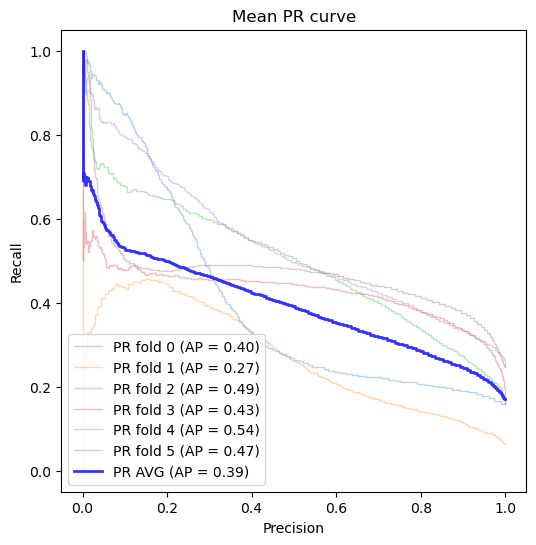

Here are the recall scores: [0.22585061 0.52176088 0.36501035 0.25631413 0.20130768 0.15260842]
Here are the precisions scores: [0.62567714 0.25078144 0.57091969 0.45933522 0.70096322 0.48174603]
Here are the accuracies scores: [0.85584077 0.87375992 0.86383929 0.83575149 0.78190104 0.75052703]
Here are the f1 scores: [0.33189655 0.33874635 0.44531447 0.32902736 0.31278695 0.23178998]


In [7]:
fig2, ax2 = plt.subplots(figsize=(6, 6))
gridsearch = [10,30,50,75,100,125,150,125,150,175,200]
for num in gridsearch:
    params = {
            'n_estimators': num,
        }
    scores = score_model_PR(RandomForestClassifier,X,y,params = params, cv=kf,plotMatrix = False, plotROC = True,ax2 = ax2,modelname = 'RF')
    print(f'Here are the recall scores: {scores[::4]}')
    print(f'Here are the precisions scores: {scores[1::4]}')
    print(f'Here are the accuracies scores: {scores[2::4]}')
    print(f'Here are the f1 scores: {scores[3::4]}')
ax2.legend(loc="upper right")

### Support Vector Machine

KeyboardInterrupt: 

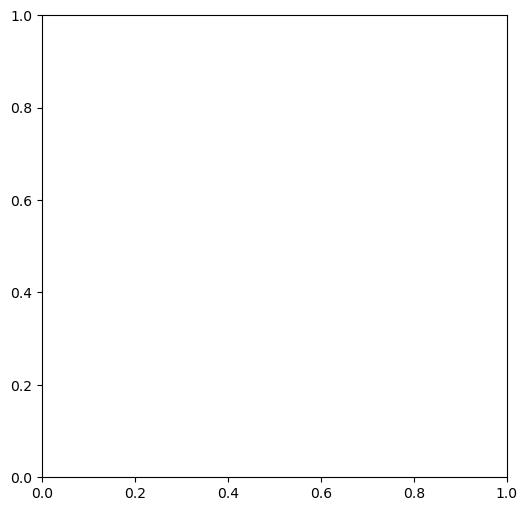

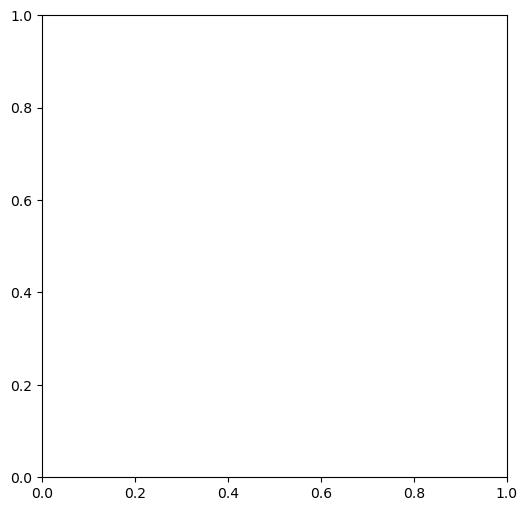

In [16]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(LinearSVC(tol =  1e-5, random_state = 0))

fig2, ax2 = plt.subplots(figsize=(6, 6))
scores = score_model_PR(clf,X,y,params = None, cv=kf,plotMatrix = False, plotROC = True, setTreshold=False,  ax2 = ax2,modelname = 'SVM')
print(f'Here are the recall scores: {scores[::4]}')
print(f'Here are the precisions scores: {scores[1::4]}')
print(f'Here are the accuracies scores: {scores[2::4]}')
print(f'Here are the f1 scores: {scores[3::4]}')
ax2.legend(loc="upper right")

TypeError: 'SVC' object is not callable

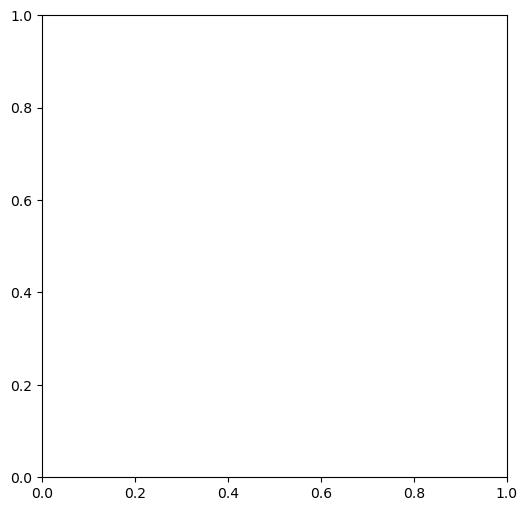

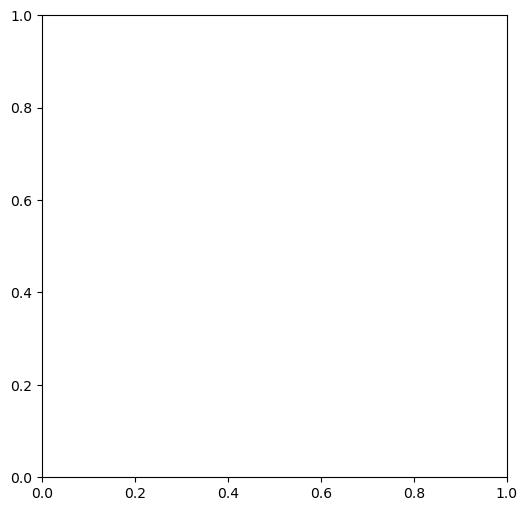

In [14]:
from sklearn.svm import SVC
model = SVC(C=1.0, probability=True, cache_size=4000)
fig2, ax2 = plt.subplots(figsize=(6, 6))
scores = score_model_PR(model,X,y,params = None, cv=kf,plotMatrix = False, plotROC = True, setTreshold=False,  ax2 = ax2,modelname = 'SVM')
print(f'Here are the recall scores: {scores[::4]}')
print(f'Here are the precisions scores: {scores[1::4]}')
print(f'Here are the accuracies scores: {scores[2::4]}')
print(f'Here are the f1 scores: {scores[3::4]}')
ax2.legend(loc="upper right")